# Fine Grain Image Classification
> Creating a fine grain image classifier - Pet Breeds!

- toc: true 
- badges: true
- comments: true
- hide: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

# Intro

For this post, I am going to make a modification to the loss function.  The goal will be to weight losses differently.

In this blog we are going to do an image classification to take pet pictures and predict the breed.  Normally, each class is treated the same when calculating the loss function.  In this post I will explore a change to take into account weighting classes differently. For example, If a picture is a maincoon, predicting a maincoon (wrong type of cat) is less egregious of an error than predicting pitbull.  I want my loss function to reflect this.

I am going to skim over loading the data and training the model, feel free to see my Fine Grain Image Classifier post from Jun-27-2020 if you want more detail on those aspect.

# Setup

### Library Import and Dataset Download

In [1]:
from fastai2.vision.all import *

seed = 42

# Download and get path for dataseet
path = untar_data(URLs.PETS) #Sample dataset from fastai2
img = (path/'images').ls()[0]


In [2]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
    get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(min_scale = 0.9,size=6)
)

In [3]:
dls = pets.dataloaders(path/"images",bs=8)

/home/isaacflath/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


# Baseline Model

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


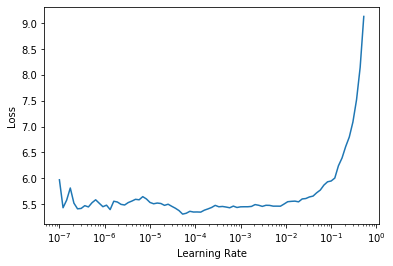

In [4]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [5]:
learn.fit_one_cycle(3, lr_steep)
learn.unfreeze()

lr_min,lr_steep = learn.lr_find()
learn.fit_one_cycle(6, lr_max=slice(lr_steep,lr_steep*20))

KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate,loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fine_tune(3)

# Adjusted Loss Function

In [53]:
pet_type = ['cat']*12+['dog']*25

In [100]:
class LabelSmoothingCrossEntropy_weighted(Module):
    y_int = True
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        
        output_pet_types = [pet_type[torch.argmax(x)] for x in output]
        target_pet_types = [pet_type[x] for x in target]        
        is_close = [output_pet_types[x] == target_pet_types[x] for x in range(0,len(target))]
                
            
        log_preds = F.log_softmax(output, dim=-1)
        
        
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            
            for x in range(0,len(loss)):
                if is_close:
                    loss[x] = loss[x]*0.9
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [101]:
learn = cnn_learner(dls, resnet34, metrics=error_rate,loss_func=LabelSmoothingCrossEntropy_weighted())

In [ ]:
learn.fine_tune(3)

In [ ]:
learn.recorder.plot_loss()

### Look at results

First lets look at some pictures.  I think it's always good to actually loook at some prediciton the model is making.

In [ ]:
learn.show_results()

Many times in classification we look at a confusion matrix.  As you can see, when we start having a lot of classes, it is really hard to make anything meaningful out of the confusion matrix.  There's just too many classes.

Next, we will take a look at some more specif data.  Let's start with a high level confusion matrix.

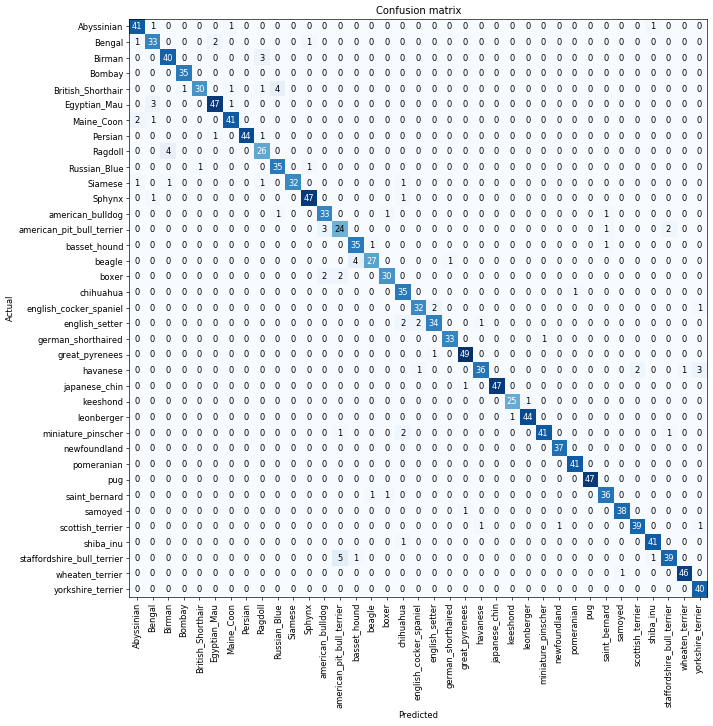

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Instead, we look at top losses to see where our model was most wrong.  We also look at the 'most confused' function whichprints which classes it gets confused on most often.

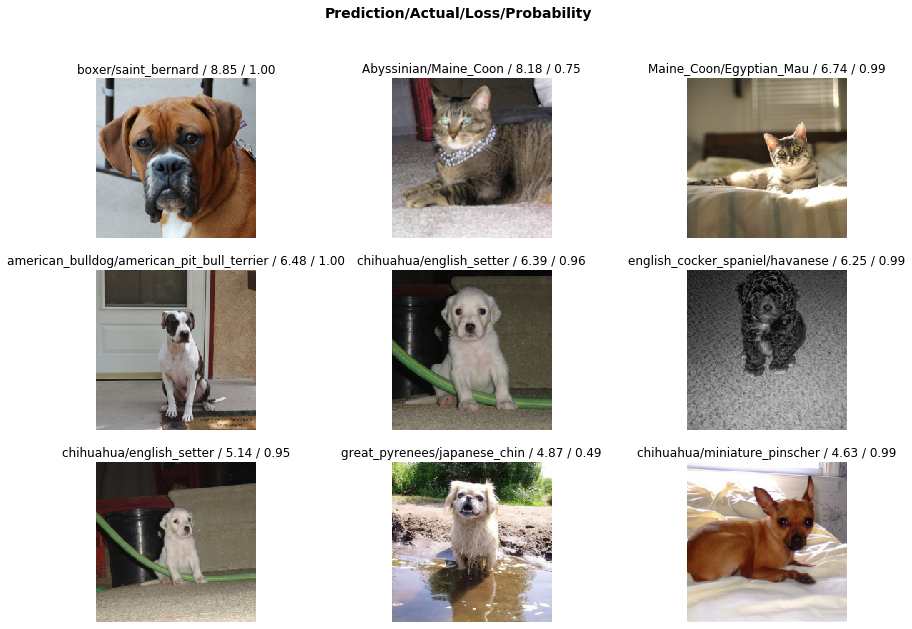

In [11]:
interp.plot_top_losses(9, figsize=(15,10))

In [12]:
interp.most_confused(min_val=3)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Ragdoll', 'Birman', 4),
 ('beagle', 'basset_hound', 4),
 ('Birman', 'Ragdoll', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('havanese', 'yorkshire_terrier', 3)]